In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import sys
from patsy import dmatrices

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir) , "da_data_repo/arizona-electricity/raw/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch12-electrictiy-temperature/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-electrictiy-temperature/output/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [5]:
sys.path.append(func)

In [6]:
from py_helper_functions import *

In [7]:
electricity = pd.read_csv(os.path.join(data_in,"electricity_resid_AZ.csv"))

In [8]:
electricity.head()

,MY,Q
0,Jan-01,2063
1,Feb-01,1790
2,Mar-01,1690
3,Apr-01,1404
4,May-01,1984


In [14]:
electricity['date']=pd.to_datetime(electricity['MY'],format='%b-%y')

In [22]:
electricity['year'] = electricity['date'].dt.year
electricity['month'] = electricity['date'].dt.month
electricity['ym']=electricity['year'].astype(str).str.cat(electricity['month'].astype(str),sep='m')

In [23]:
electricity.head()

,MY,Q,date,year,month,ym
0,Jan-01,2063,2001-01-01,2001,1,2001m1
1,Feb-01,1790,2001-02-01,2001,2,2001m2
2,Mar-01,1690,2001-03-01,2001,3,2001m3
3,Apr-01,1404,2001-04-01,2001,4,2001m4
4,May-01,1984,2001-05-01,2001,5,2001m5


In [24]:
electricity = electricity[['Q','date','ym']]

In [28]:
electricity['lnQ']=electricity['Q'].map(np.log)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
electricity['lnQ']

0      7.631917
1      7.489971
2      7.432484
3      7.247081
4      7.592870
         ...   
202    7.564757
203    7.695303
204    7.682482
205    7.548029
206    7.592366
Name: lnQ, Length: 207, dtype: float64

In [31]:
climate = pd.read_csv(os.path.join(data_in,"climate_Phoenix_AZ.csv"))

In [35]:
climate['tempdate']=pd.to_datetime(climate['DATE'],format='%Y-%m')

In [38]:
climate['year'] = climate['tempdate'].dt.year
climate['month'] = climate['tempdate'].dt.month
climate['ym']=climate['year'].astype(str).str.cat(climate['month'].astype(str),sep='m')

In [39]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1


In [43]:
climate['ndays']=30
climate.loc[climate['month'].isin([1, 3, 5, 7, 8, 10, 12]),'ndays']=31
climate.loc[climate['month']==2,'ndays']=28

In [44]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym,ndays
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9,30
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10,31
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11,30
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12,31
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1,31


In [45]:
for x in ["CLDD", "HTDD", "DX70", "DX90"]:
    climate[x +'_avg']=climate[x]/climate['ndays']

In [46]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [47]:
climate[["CLDD_avg", "HTDD_avg", "DX70_avg", "DX90_avg"]].describe()

,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
count,332.000000,332.000000,332.000000,332.000000
mean,12.698136,2.422917,0.822810,0.468293
std,11.576086,3.525208,0.257170,0.431420
min,0.000000,0.000000,0.107143,0.000000
25%,0.666667,0.000000,0.694643,0.000000
50%,10.163441,0.131183,1.000000,0.393548
75%,24.900000,4.120680,1.000000,0.967742
max,33.290323,12.129032,1.000000,1.000000


In [48]:
climate = climate.drop(columns=["DATE", "tempdate", "STATION", "NAME"])

In [49]:
climate.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,676,0,30,28,0,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,425,0,31,24,0,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,98,0,26,0,70,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,0,0,14,0,353,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,0,0,6,0,283,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [50]:
data = pd.merge(climate,electricity,on='ym',how='inner')

In [53]:
data = data[(data['year']>=2001) & (data['year']<=2017)].reset_index()

In [57]:
data.loc[data['Q'].notnull(),['year','month']].describe()

,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [58]:
data.loc[data['CLDD'].notnull(),['year','month']].describe()

,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [61]:
data[["Q","lnQ","CLDD_avg","HTDD_avg"]].describe()

,Q,lnQ,CLDD_avg,HTDD_avg
count,204.000000,204.000000,204.000000,204.000000
mean,2636.392157,7.827744,13.317995,2.283919
std,864.697489,0.309525,11.779998,3.499287
min,1404.000000,7.247081,0.000000,0.000000
25%,1938.250000,7.569541,1.104551,0.000000
50%,2338.500000,7.757263,10.333333,0.016667
75%,3309.750000,8.104615,25.875000,3.737500
max,4674.000000,8.449771,33.290323,12.096774


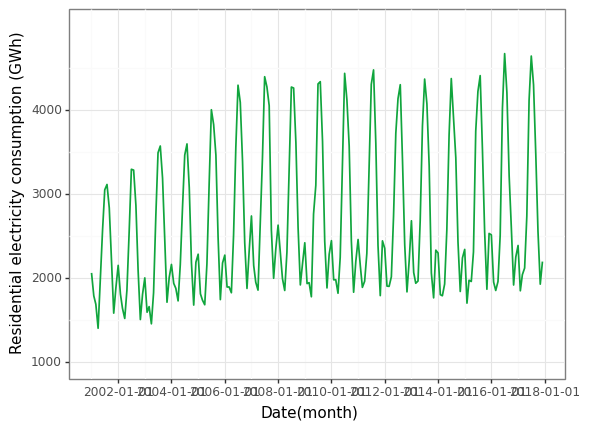

<ggplot: (314670642)>

In [64]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'Q'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "Residential electricity consumption (GWh)")
 + scale_y_continuous(limits = [1000,5000], breaks = seq(1000,5000,1000))
 + theme_bw() 
)
g1

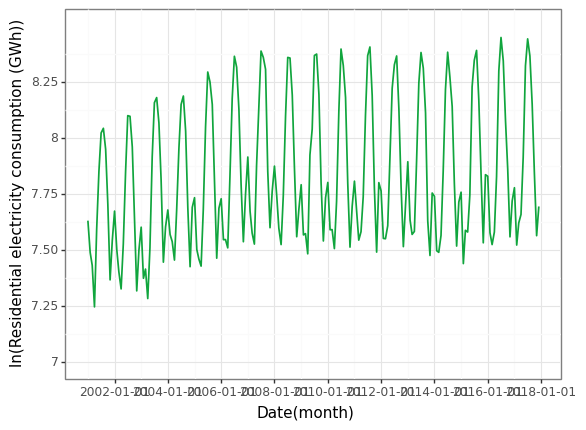

<ggplot: (316926286)>

In [66]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'lnQ'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(limits = [7,8.5], breaks = seq(7,8.5,0.25))
 + theme_bw() 
)
g1

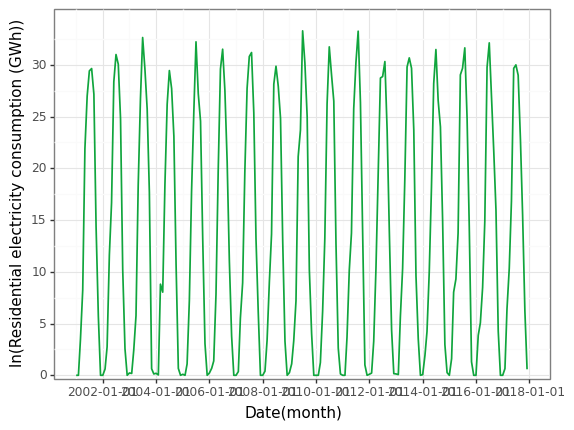

<ggplot: (-9223372036537925218)>

In [67]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'CLDD_avg'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(expand = [0.01,0.01],limits = [0,35], breaks = seq(0,35,5)) 
 + theme_bw() 
)
g1

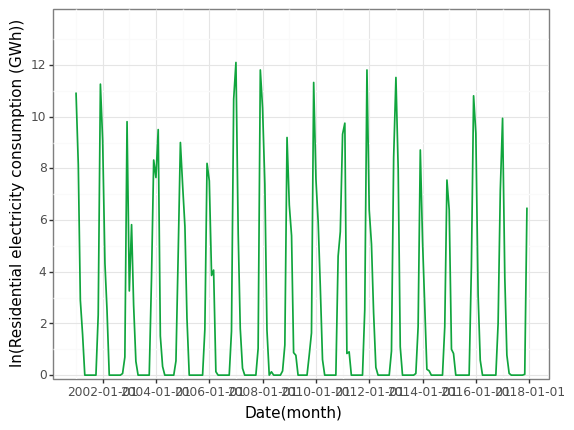

<ggplot: (317136872)>

In [68]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'HTDD_avg'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(expand = [0.01,0.01],limits = [0,14], breaks = seq(0,14,2))
 + theme_bw() 
)
g1

In [69]:
#Serial correlation

In [76]:
for x in ["lnQ","CLDD_avg", "HTDD_avg", "DX90_avg"]:
    data['D'+x]=data[x]-data[x].shift()

In [77]:
data

,index,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,...,Q,date,lnQ,DlnQ,DCLDD,DHTDD,DDX90,DCLDD_avg,DHTDD_avg,DDX90_avg
0,0,0,0,11,0,339,2001,1,2001m1,31,...,2063,2001-01-01,7.631917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,11,0,228,2001,2,2001m2,28,...,1790,2001-02-01,7.489971,-0.141946,0.0,-111.0,0.0,0.000000,-2.792627,0.000000
2,2,108,0,23,2,90,2001,3,2001m3,31,...,1690,2001-03-01,7.432484,-0.057487,108.0,-138.0,2.0,3.483871,-5.239631,0.064516
3,3,247,0,27,11,47,2001,4,2001m4,30,...,1404,2001-04-01,7.247081,-0.185403,139.0,-43.0,9.0,4.749462,-1.336559,0.302151
4,4,679,0,31,27,0,2001,5,2001m5,31,...,1984,2001-05-01,7.592870,0.345790,432.0,-47.0,16.0,13.669892,-1.566667,0.504301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,199,899,0,31,31,0,2017,8,2017m8,31,...,4303,2017-08-01,8.367068,-0.076479,-31.0,0.0,0.0,-1.000000,0.000000,0.000000
200,200,685,0,30,26,0,2017,9,2017m9,30,...,3470,2017-09-01,8.151910,-0.215158,-214.0,0.0,-5.0,-6.166667,0.000000,-0.133333
201,201,480,0,31,26,0,2017,10,2017m10,31,...,2557,2017-10-01,7.846590,-0.305320,-205.0,0.0,0.0,-7.349462,0.000000,-0.027957
202,202,187,0,30,0,1,2017,11,2017m11,30,...,1929,2017-11-01,7.564757,-0.281833,-293.0,1.0,-26.0,-9.250538,0.033333,-0.838710


In [78]:
#Linear regressions

In [79]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg",data)

In [86]:
reg = sm.OLS(y, X).fit()
reg_results = reg.get_robustcov_results(cov_type='HAC',maxlags=18)

In [88]:
reg1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1114.
Date:                Thu, 27 Aug 2020   Prob (F-statistic):          3.65e-109
Time:                        16:03:56   Log-Likelihood:                 182.98
No. Observations:                 203   AIC:                            -360.0
Df Residuals:                     200   BIC:                            -350.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.002      0.477      0.634      -0.003       0.005
DCLDD_avg      0.0307      0.001     33.658      0.000       0.029       0.032
DHTDD_avg      0.0367      0.003     10.609      0.000       0.030       0.044
==============================================================================
Omnibus:                        4.221   Durbin-Watson:                   2.547
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                4.632
Skew:                          -0.164   Prob(JB):                       0.0986
Kurtosis:                       3.664   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [90]:
data['month'],_=pd.factorize(data['month'])

In [91]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg + month",data)

In [92]:
reg = sm.OLS(y, X).fit()
reg_results = reg.get_robustcov_results(cov_type='HAC',maxlags=18)

In [93]:
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     709.7
Date:                Thu, 27 Aug 2020   Prob (F-statistic):          5.63e-106
Time:                        16:10:04   Log-Likelihood:                 183.76
No. Observations:                 203   AIC:                            -359.5
Df Residuals:                     199   BIC:                            -346.3
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0211      0.018     -1.200      0.232      -0.056       0.014
DCLDD_avg      0.0315      0.001     33.387      0.000       0.030       0.033
DHTDD_avg      0.0341      0.005      7.327      0.000       0.025       0.043
month          0.0040      0.003      1.274      0.204      -0.002       0.010
==============================================================================
Omnibus:                        2.695   Durbin-Watson:                   2.560
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.778
Skew:                          -0.044   Prob(JB):                        0.249
Kurtosis:                       3.566   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [96]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg + month",data)
reg = sm.OLS(y, X).fit()
reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     281.6
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           2.47e-71
Time:                        16:12:56   Log-Likelihood:                 183.76
No. Observations:                 203   AIC:                            -359.5
Df Residuals:                     199   BIC:                            -346.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0211      0.019     -1.104      0.271      -0.059       0.017
DCLDD_avg      0.0315      0.001     24.992      0.000       0.029       0.034
DHTDD_avg      0.0341      0.003     10.737      0.000       0.028       0.040
month          0.0040      0.003      1.243      0.215      -0.002       0.010
==============================================================================
Omnibus:                        2.695   Durbin-Watson:                   2.560
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.778
Skew:                          -0.044   Prob(JB):                        0.249
Kurtosis:                       3.566   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
reg_results = reg.get_robustcov_results(cov_type='HAC',maxlags=18)
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     709.7
Date:                Thu, 27 Aug 2020   Prob (F-statistic):          5.63e-106
Time:                        16:13:00   Log-Likelihood:                 183.76
No. Observations:                 203   AIC:                            -359.5
Df Residuals:                     199   BIC:                            -346.3
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0211      0.018     -1.200      0.232      -0.056       0.014
DCLDD_avg      0.0315      0.001     33.387      0.000       0.030       0.033
DHTDD_avg      0.0341      0.005      7.327      0.000       0.025       0.043
month          0.0040      0.003      1.274      0.204      -0.002       0.010
==============================================================================
Omnibus:                        2.695   Durbin-Watson:                   2.560
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.778
Skew:                          -0.044   Prob(JB):                        0.249
Kurtosis:                       3.566   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [ ]:
#can I specify shifts on the fly?